In [1]:
import cellcharter as cc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import scanpy as sc
import os
import matplotlib.patches as mpatches
import anndata as ad
from scipy.cluster.hierarchy import linkage, leaves_list
import scikit_posthocs as sp
from scipy.stats import kruskal
import json
import warnings
warnings.filterwarnings("ignore")

/Users/lukashat/miniforge3/envs/cellcharter_scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [ ]:
extension = 'svg'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_4/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_4/{extension}/'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/neighborhood_color_map.json', 'r') as f:
    neighborhood_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/phenotype_color_map.json', 'r') as f:
    phenotype_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease_color_map.json', 'r') as f:
    disease_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease3_color_map.json', 'r') as f:
    disease3_color_map = json.load(f)
neighborhood_colors = [neighborhood_color_map[cat] for cat in list(adata.obs['cellcharter_CN'].cat.categories)]
neighborhood_colors = ListedColormap(neighborhood_colors)
phenotype_colors = [phenotype_color_map[cat] for cat in list(adata.obs['Phenotype4'].cat.categories)]
phenotype_colors = ListedColormap(phenotype_colors)
disease_colors = [disease_color_map[cat] for cat in list(adata.obs['disease2'].cat.categories)]
disease_colors = ListedColormap(disease_colors)
disease3_colors = [disease3_color_map[cat] for cat in list(adata.obs['disease3'].cat.categories)]
disease3_colors = ListedColormap(disease3_colors)

#  Supplement

In [3]:
autok = cc.tl.ClusterAutoK.load("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/downstream/neighborhoods/cellcharter/autok_dmr_scale_layer3")

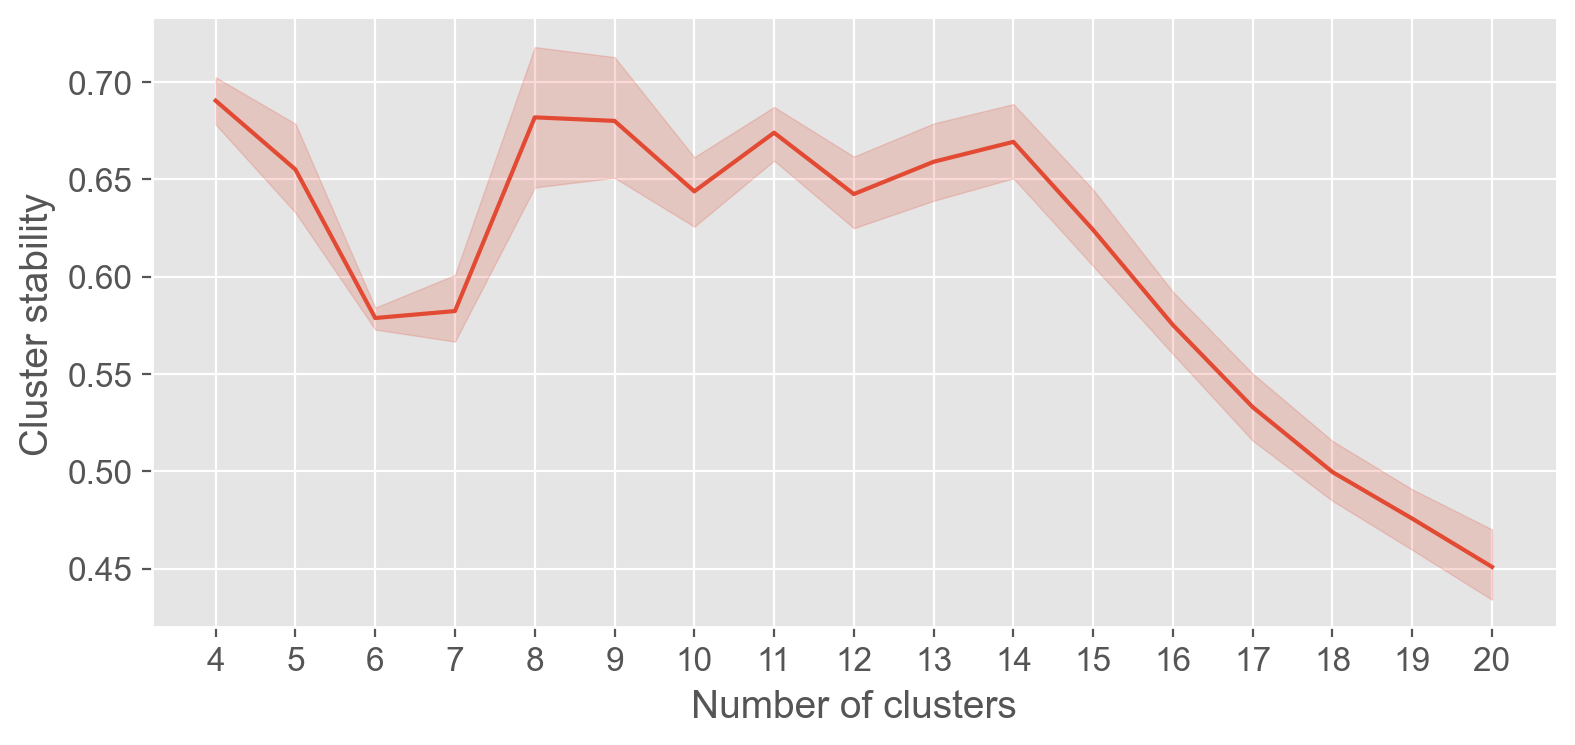

In [4]:
plt.style.use('ggplot')
ax = cc.pl.autok_stability(autok, return_ax=True)
ax.figure.set_size_inches(9, 4) 
ax.set_ylabel("Cluster stability", fontsize=14)
ax.set_xlabel("Number of clusters", fontsize=14)
ax.set_xticklabels(ax.get_xticks(), fontsize=12)
ax.set_yticklabels([f"{y:.2f}" for y in ax.get_yticks()], fontsize=12)
plt.savefig(os.path.join(save_path, f'stable_clusters.{extension}'))

# B

In [5]:
cc.gr.enrichment(adata, group_key=f'cellcharter_CN', label_key='Phenotype4', pvalues=True, n_perms=250)

100%|██████████| 250/250 [00:11<00:00, 20.91it/s]


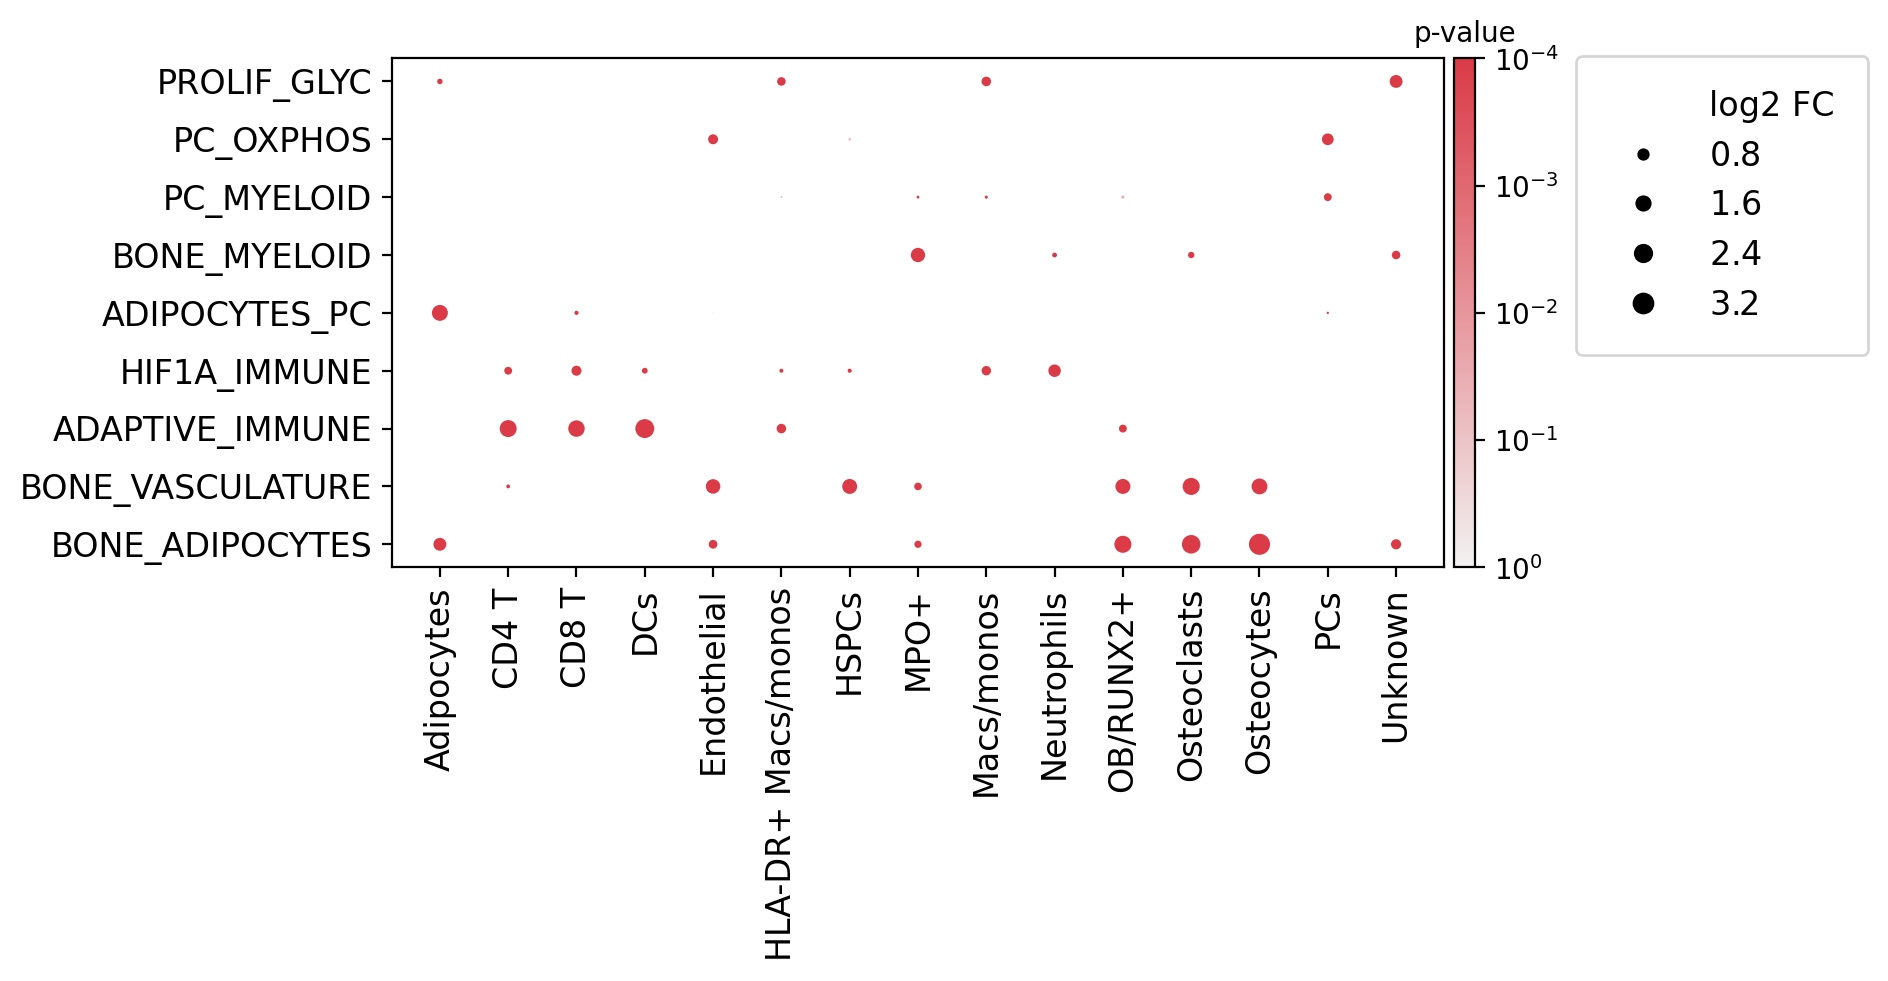

In [6]:
plt.style.use('default')
cc.pl.enrichment(adata, group_key=f'cellcharter_CN', label_key='Phenotype4', show_pvalues=True, figsize=(8,5), group_cluster=True, fontsize=12, dot_scale=1, save= os.path.join(save_path, f'enrichment_phenotypes+pvalues.{extension}'))

# C

In [7]:
adata.obs['cellcharter_CN'].value_counts()

cellcharter_CN
PC_MYELOID          189316
HIF1A_IMMUNE        167907
PROLIF_GLYC         144341
PC_OXPHOS           130112
ADIPOCYTES_PC       111044
BONE_MYELOID        107259
BONE_VASCULATURE     90590
ADAPTIVE_IMMUNE      37930
BONE_ADIPOCYTES      28628
Name: count, dtype: int64

In [8]:
new_order = ['PC_OXPHOS', 'PROLIF_GLYC', 'PC_MYELOID', 'BONE_MYELOID', 
             'ADIPOCYTES_PC', 'ADAPTIVE_IMMUNE', 'HIF1A_IMMUNE', 
             'BONE_ADIPOCYTES', 'BONE_VASCULATURE']
adata.obs['cellcharter_CN'] = adata.obs['cellcharter_CN'].cat.reorder_categories(new_order, ordered=True)

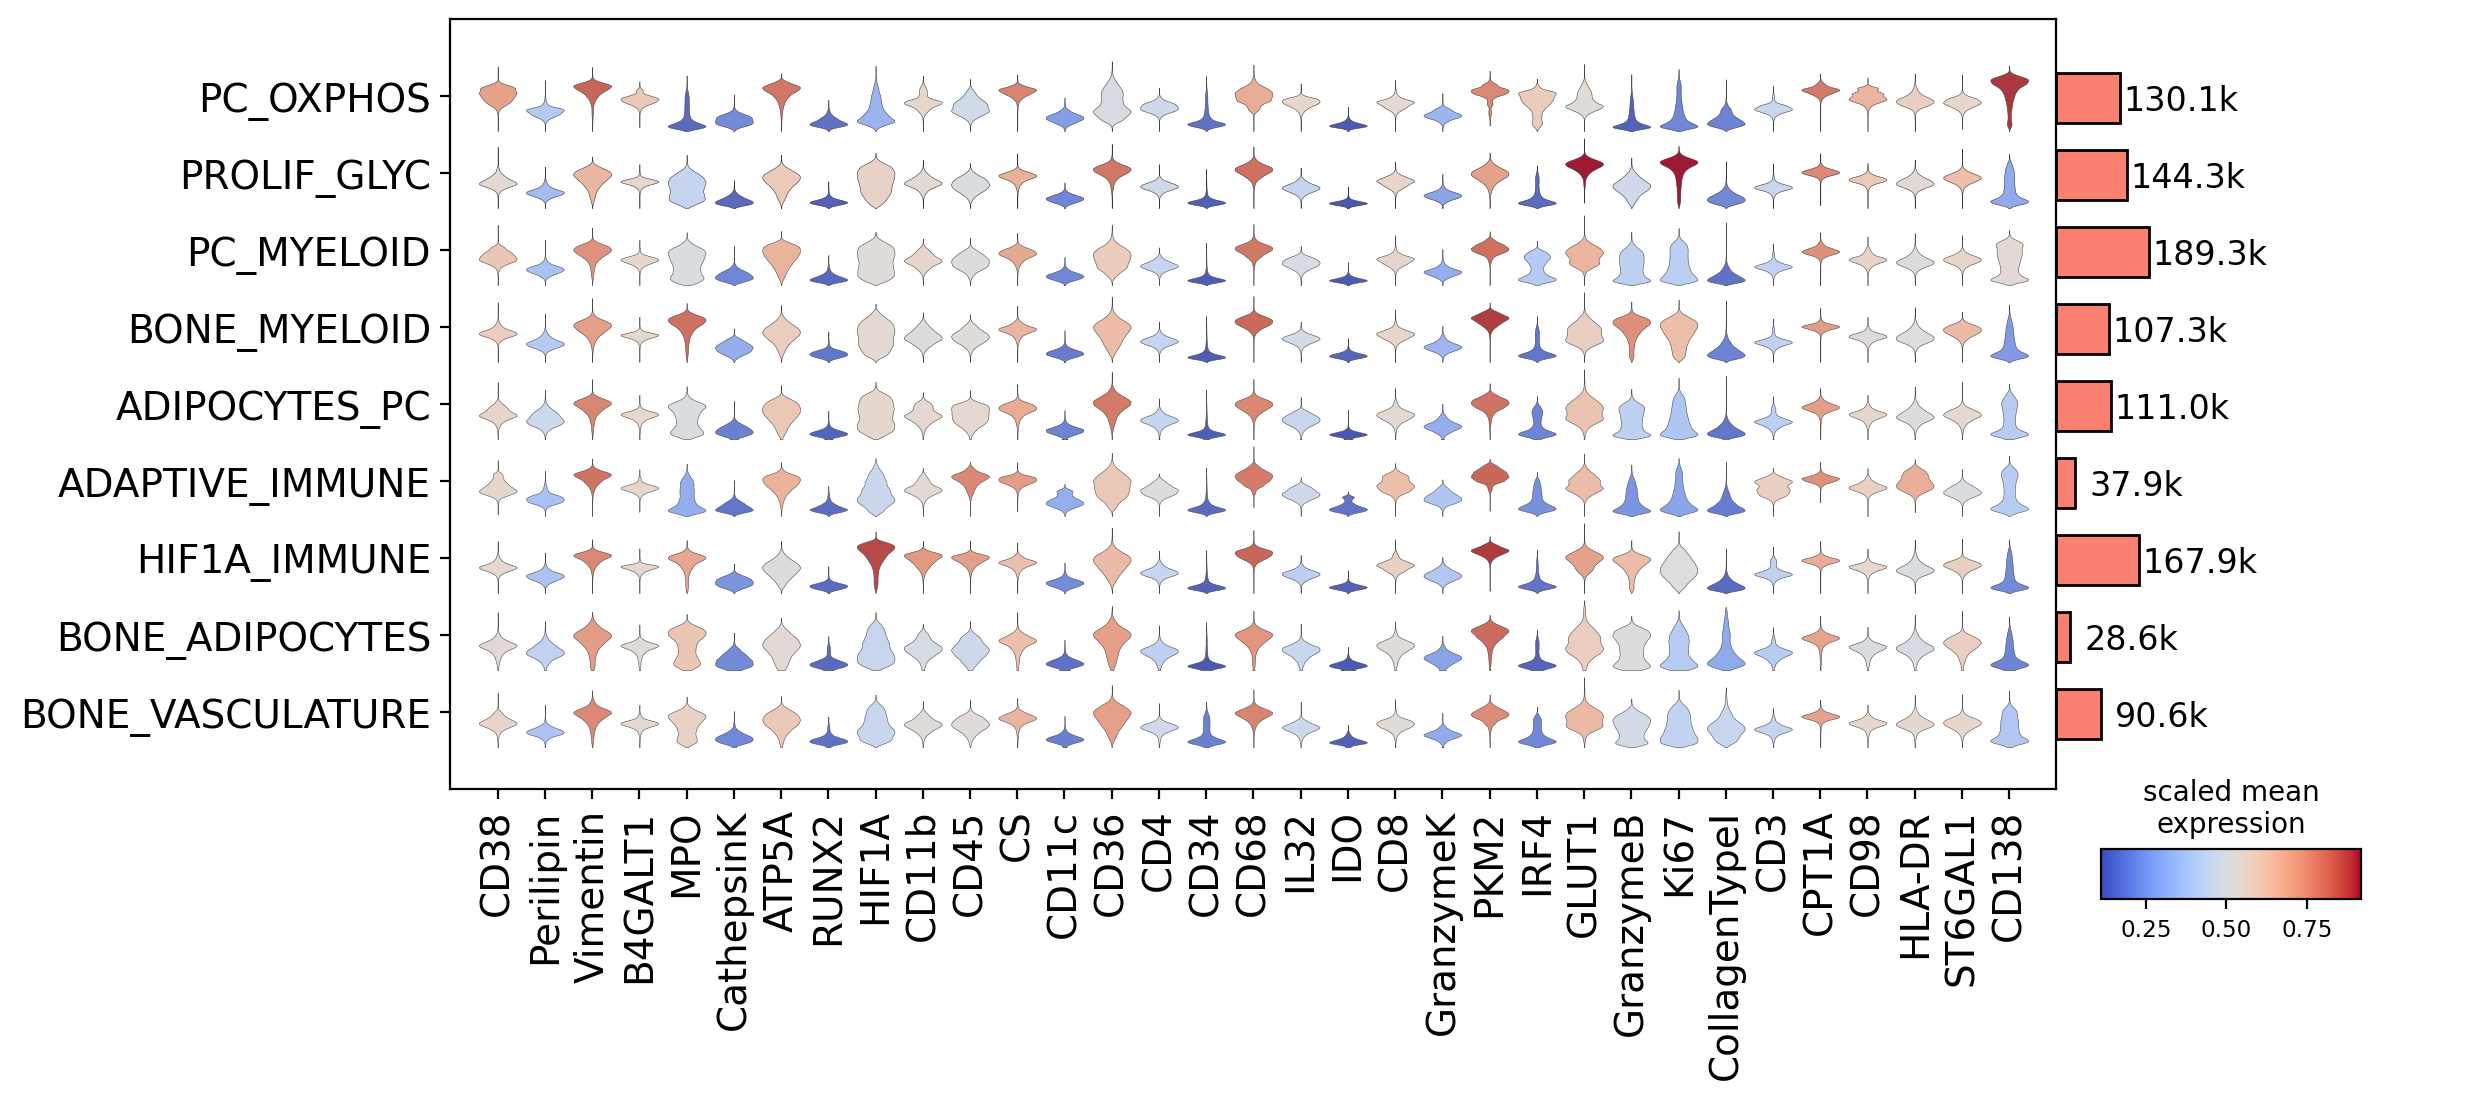

In [9]:
plot = sc.pl.stacked_violin(adata, adata.var_names, groupby='cellcharter_CN', cmap='coolwarm', use_raw=False, density_norm='area', figsize=(13, 5), return_fig=True)
plot.add_totals()
axes = plot.get_axes()
ax = axes['mainplot_ax']
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14) 
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
group_ax = axes['group_extra_ax']
for text in group_ax.texts:
    text.set_fontsize(12)
    current_pos = text.get_position()
    text.set_position((current_pos[0] + 12, current_pos[1]+4))
cax = axes['color_legend_ax']
cax.set_title('scaled mean\nexpression', fontsize=10)
cax.set_position([0.76, 0, 0.1, 0.05])
fig = axes['mainplot_ax'].figure
fig.savefig(os.path.join(save_path, f'stacked_violin.{extension}'), 
            dpi=300, 
            bbox_inches='tight')

# G

In [10]:
grouped_df = pd.crosstab(
    [adata.obs['patient_ID'], adata.obs['disease3']], 
    adata.obs['cellcharter_CN'],
    normalize='index'
) 
summary_stats = grouped_df.groupby(level='disease3').agg(['mean'])
summary_stats.columns = summary_stats.columns.get_level_values(0)
summary_stats = summary_stats.reindex(['MM', 'SMM', 'MGUS'])
summary_stats

cellcharter_CN,PC_OXPHOS,PROLIF_GLYC,PC_MYELOID,BONE_MYELOID,ADIPOCYTES_PC,ADAPTIVE_IMMUNE,HIF1A_IMMUNE,BONE_ADIPOCYTES,BONE_VASCULATURE
disease3,,,,,,,,,
MM,0.131662,0.139629,0.182315,0.105781,0.110682,0.039663,0.164168,0.032195,0.093906
SMM,0.041268,0.170131,0.224042,0.119444,0.123092,0.023032,0.182722,0.039166,0.077102
MGUS,0.038932,0.191855,0.183832,0.122173,0.138390,0.024796,0.188366,0.031456,0.080200


In [11]:
plt.style.use('default')

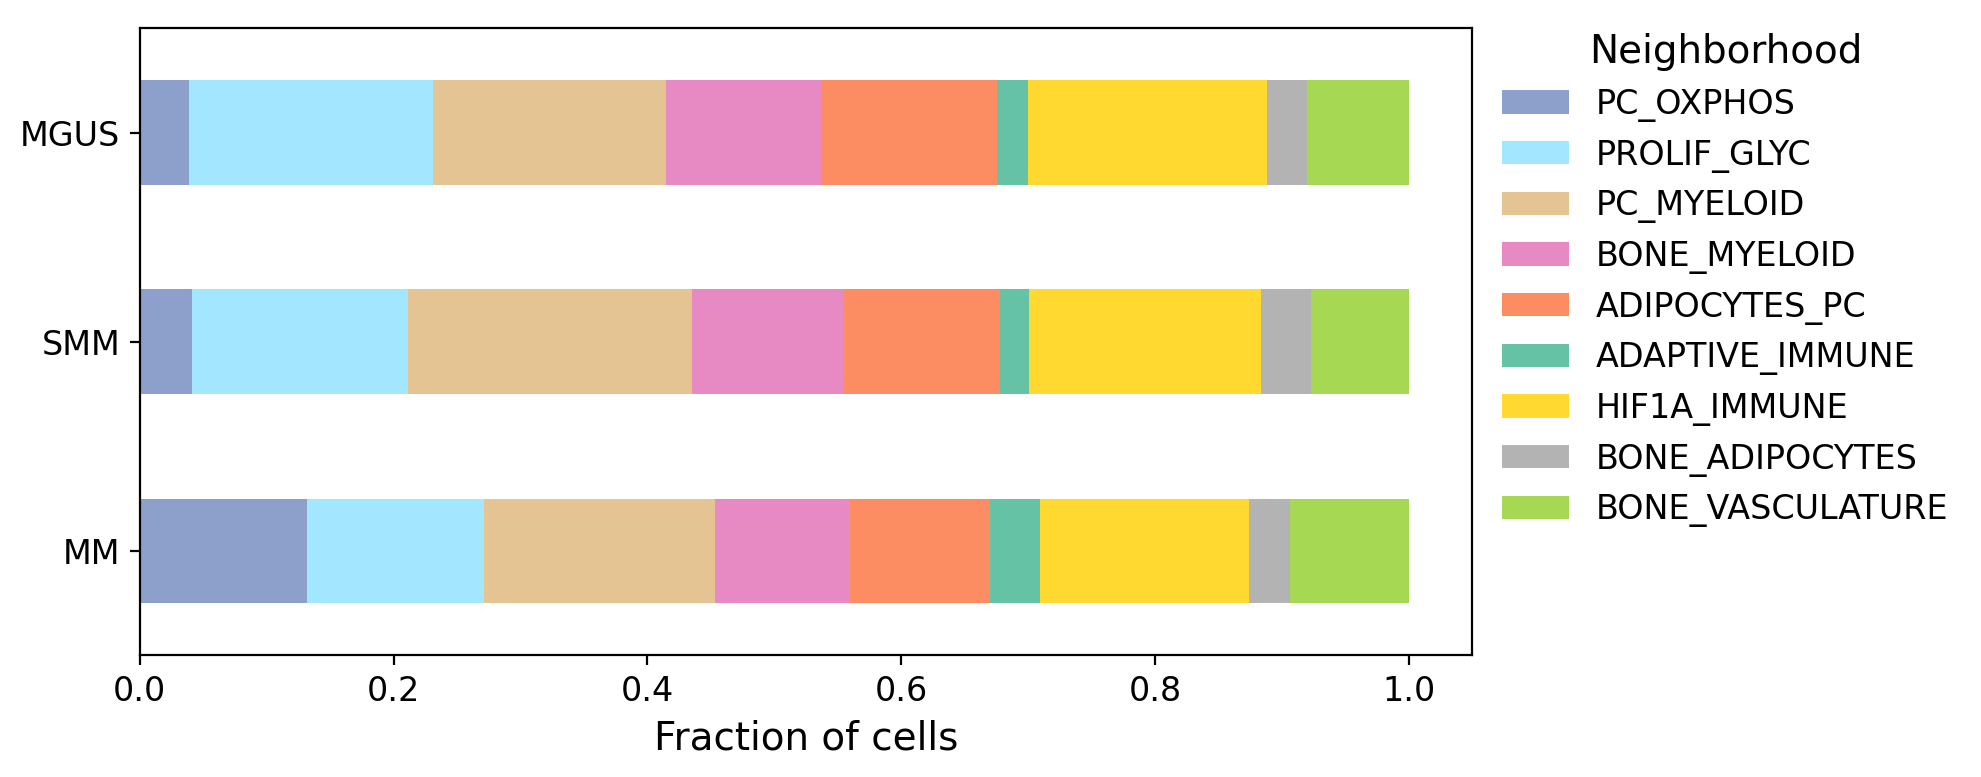

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = summary_stats.plot(kind='barh', stacked=True, color=neighborhood_color_map, ax=ax)
plt.title('')
ax.set_xlabel('Fraction of cells', fontsize=14)
ax.set_xticklabels([f"{y:.1f}" for y in ax.get_xticks()], fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.ylabel('')
plt.legend(title='Neighborhood', bbox_to_anchor=(1, 1.04), loc='upper left', fontsize=12, title_fontsize=14, framealpha=0)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'neighborhood_compositions_mean.{extension}'), dpi=300)

# F

In [13]:
grouped_df = pd.crosstab(
    [adata.obs['patient_ID'], adata.obs['disease3']], 
    adata.obs['cellcharter_CN'],
    normalize='index'
) 

In [14]:
df = grouped_df.reset_index()
df = df[[col for col in df.columns if col in ['patient_ID', 'disease3', 'PC_OXPHOS', 'ADAPTIVE_IMMUNE']]]
df

cellcharter_CN,patient_ID,disease3,PC_OXPHOS,ADAPTIVE_IMMUNE
0,IMC01,MM,0.042081,0.055954
1,IMC02,MGUS,0.017934,0.006246
2,IMC03,MGUS,0.101356,0.011822
3,IMC04,MGUS,0.025603,0.034313
4,IMC05,SMM,0.038157,0.004996
...,...,...,...,...
71,IMC90.1,MM,0.134916,0.011288
72,IMC92,MM,0.052662,0.009502
73,IMC93,MM,0.073692,0.021389
74,IMC95,MM,0.046908,0.005060


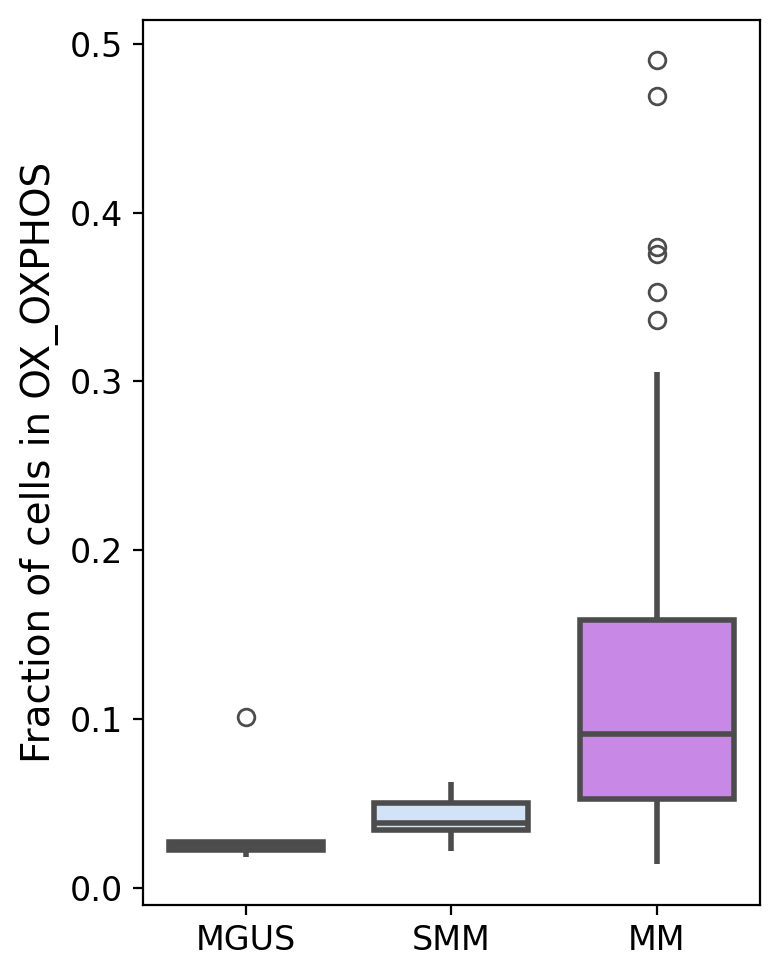

In [15]:
fig, ax = plt.subplots(figsize=(4, 5))
sns.boxplot(data=df, x='disease3', y='PC_OXPHOS', order=['MGUS', 'SMM', 'MM'], palette=disease3_color_map, showcaps=False, linewidth=2, width=0.75)
plt.xlabel('')
plt.ylabel('Fraction of cells in OX_OXPHOS', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'PC_OXPHOS_fraction.{extension}'), bbox_inches='tight')

In [16]:
groups = [group['PC_OXPHOS'].values for _, group in df.groupby('disease3')]
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis H-stat: {kruskal_result.statistic:.3f}, p-val: {kruskal_result.pvalue:.4f}")

Kruskal-Wallis H-stat: 14.733, p-val: 0.0006


In [17]:
dunn_results = sp.posthoc_dunn(
    df,
    val_col='PC_OXPHOS',
    group_col='disease3',
    p_adjust='Bonferroni',
)
print("\nDunn's posthoc results:")
dunn_results


Dunn's posthoc results:


,MGUS,MM,SMM
MGUS,1.000000,0.012784,1.000000
MM,0.012784,1.000000,0.016496
SMM,1.000000,0.016496,1.000000


# Supplement

In [18]:
df = pd.crosstab(
    index=[adata.obs['patient_ID'], adata.obs['disease3']],
    columns=adata.obs['cellcharter_CN'],
    normalize='index'
)
df = df.reindex(['MM', 'SMM', 'MGUS'], level=1)
df = df.sort_index(level=1, key=lambda x: pd.Categorical(x, categories=['MGUS', 'SMM', 'MM'], ordered=True))
df

,cellcharter_CN,PC_OXPHOS,PROLIF_GLYC,PC_MYELOID,BONE_MYELOID,ADIPOCYTES_PC,ADAPTIVE_IMMUNE,HIF1A_IMMUNE,BONE_ADIPOCYTES,BONE_VASCULATURE
patient_ID,disease3,,,,,,,,,
IMC02,MGUS,0.017934,0.256246,0.238312,0.086278,0.097341,0.006246,0.201374,0.040239,0.056031
IMC03,MGUS,0.101356,0.116237,0.174272,0.101025,0.090195,0.011822,0.150876,0.031994,0.222222
IMC04,MGUS,0.025603,0.173764,0.181418,0.158895,0.153792,0.034313,0.178251,0.047862,0.046102
IMC72,MGUS,0.027261,0.162636,0.175824,0.143623,0.174053,0.057086,0.219721,0.010159,0.029638
IMC82,MGUS,0.022505,0.250394,0.149332,0.121043,0.176570,0.014513,0.191608,0.027027,0.047008
...,...,...,...,...,...,...,...,...,...,...
IMC90.1,MM,0.134916,0.118100,0.172596,0.090308,0.136473,0.011288,0.256520,0.023900,0.055897
IMC92,MM,0.052662,0.133715,0.235375,0.147338,0.103492,0.009502,0.241557,0.057241,0.019118
IMC93,MM,0.073692,0.226446,0.171112,0.106512,0.144787,0.021389,0.162019,0.041046,0.052996


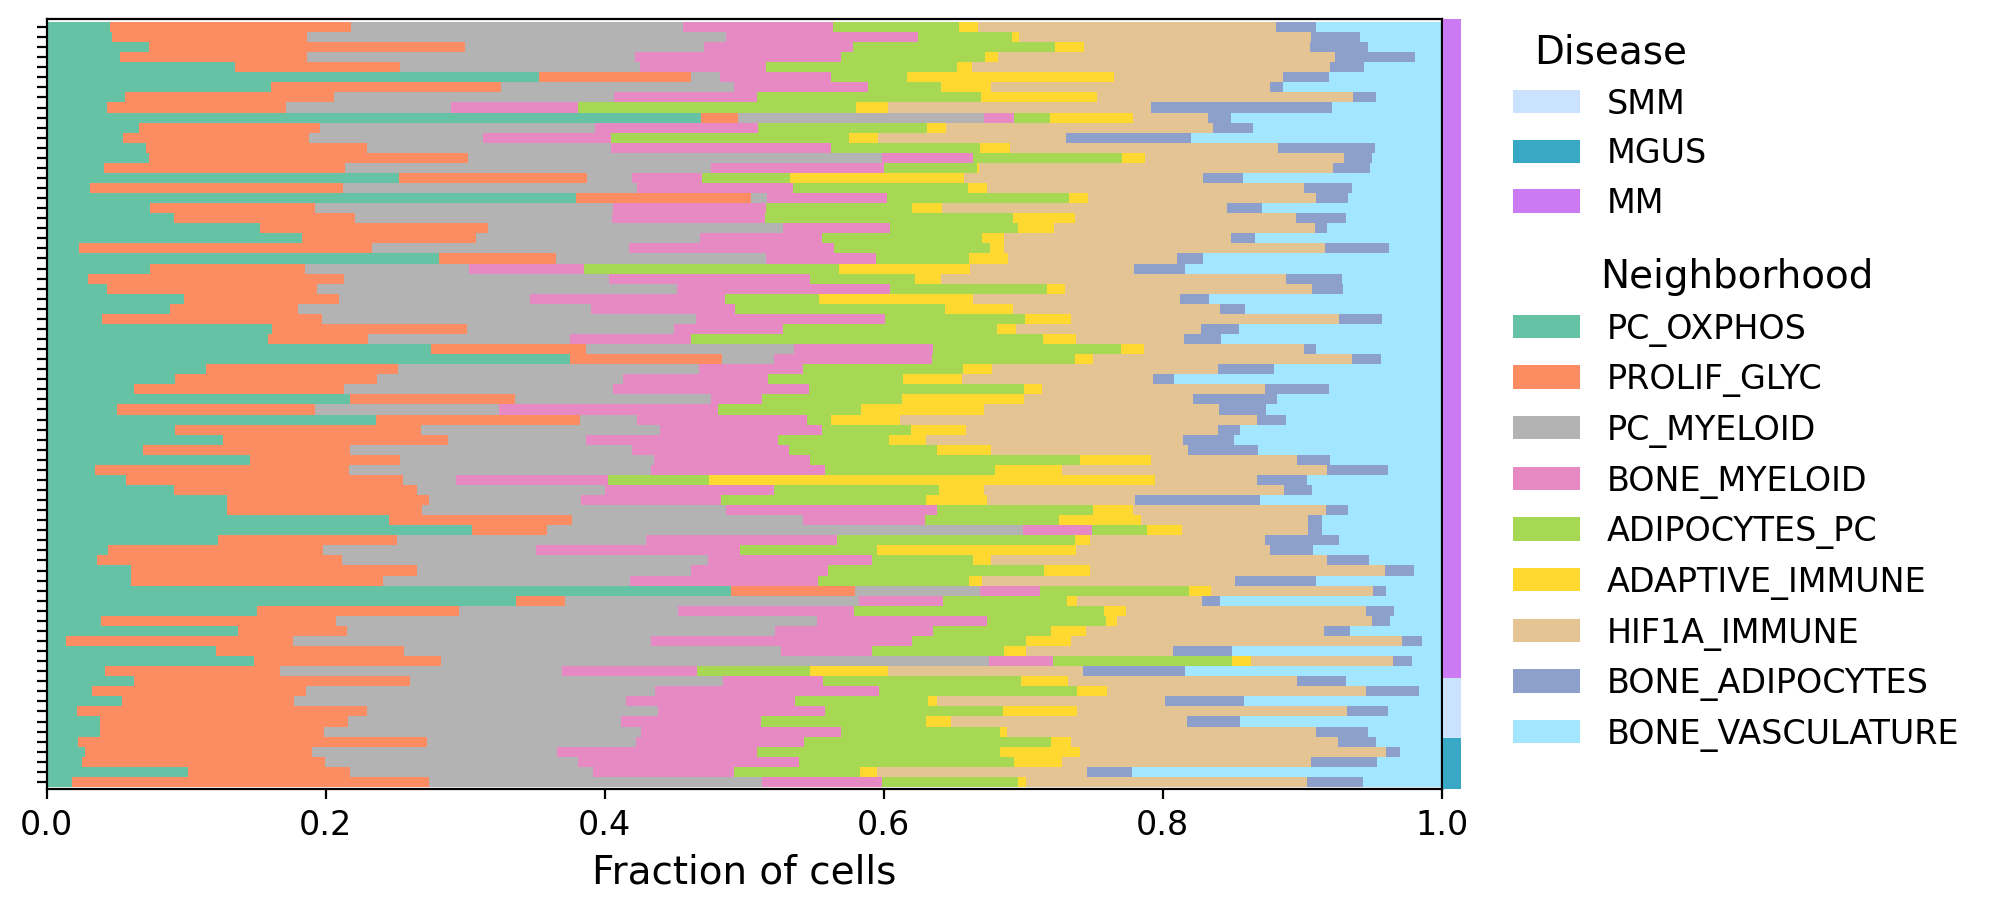

In [19]:
fig, ax = plt.subplots(figsize=(9, 5))
disease_labels = df.index.get_level_values('disease3')
disease_colors = [disease3_color_map[d] for d in disease_labels]

# Main plot
df.plot(kind='barh', stacked=True, colormap=neighborhood_colors, width=1, ax=ax)
ax.xaxis.grid(False)  # Explicit x-axis grid removal
ax.yaxis.grid(False)
ax.set_ylabel('')
ax.set_xlabel('Fraction of cells', fontsize=14)
ax.set_yticklabels('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_xlim(0, 1)

pos = ax.get_position()
pad = 0.001  
cbar_width = 0.01  

pos = ax.get_position()
ax_disease = fig.add_axes([
    pos.x1 + pad,
    pos.y0,
    cbar_width,
    pos.height
]) 


n_patients = len(df)
disease_colors_array = np.array(disease_colors).reshape(n_patients, 1, 3)
ax_disease.imshow(disease_colors_array, 
                aspect='auto', 
                extent=[0, 1, -0.5, n_patients-0.5], 
                origin='lower')

ax_disease.set_xticks([])
ax_disease.set_yticks([])
ax_disease.set_xticklabels([])
ax_disease.set_yticklabels([])

disease_handles = [
    mpatches.Patch(facecolor=color, label=disease)
    for disease, color in disease3_color_map.items()
]


disease_legend = ax.legend(
    handles=disease_handles,
    title='Disease',
    title_fontsize=14,
    loc='upper left',
    framealpha=0,
    bbox_to_anchor=(1.03, 1.022),  
    fontsize=12)
ax.add_artist(disease_legend)
ax.legend(title='Neighborhood', loc='upper left', framealpha=0, bbox_to_anchor=(1.03, 0.73), fontsize=12, title_fontsize=14)
ax_disease.set_axis_off()
fig.savefig(os.path.join(save_path, f"neighborhood_barplot_patients.{extension}"), bbox_inches='tight')

# E

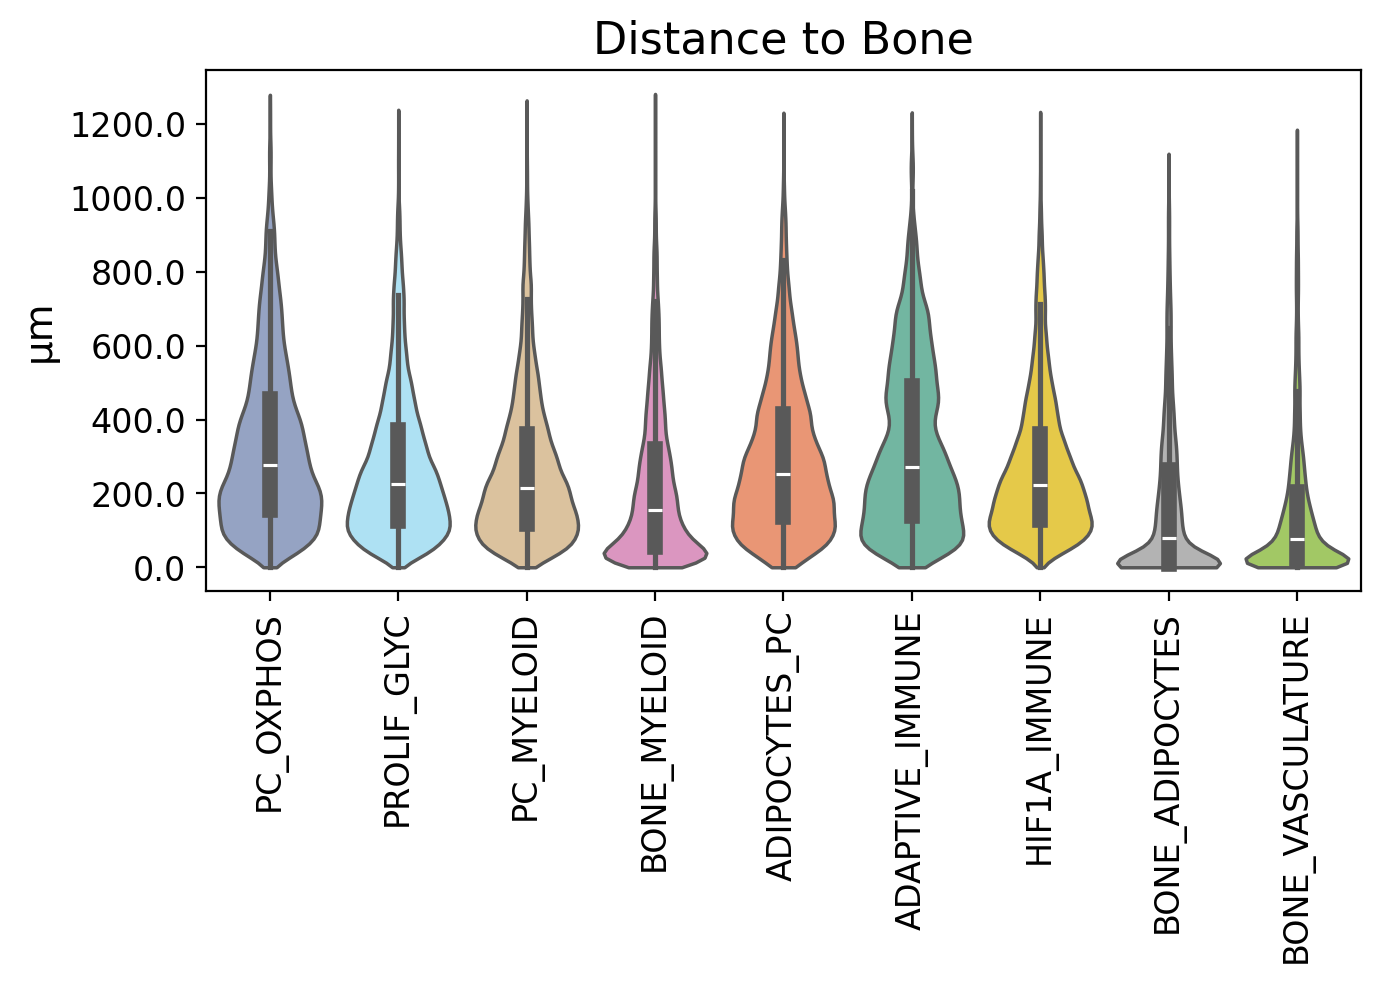

In [23]:
fig,ax = plt.subplots(figsize=(7, 5))
sc.pl.violin(adata, keys='distance_to_bone_corrected', groupby='cellcharter_CN', palette=neighborhood_color_map, stripplot=False, rotation=90, inner='box', show=False, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('µm', fontsize=14)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)
ax.set_title('Distance to Bone', fontsize=16)
plt.tight_layout()
fig.savefig(os.path.join(save_path, f'distance_to_bone_neighborhoods.{extension}'))